In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from pprint import pprint


from datetime import datetime

# I have a config file on my computer, you are going to have to add your own with the api key
from config import omdb_key

netflix_data = "resources/netflix daily top 10.csv"
netflix_titles_source = "resources/netflix_titles.csv"
netflix = pd.read_csv(netflix_data)
netflix_titles = pd.read_csv(netflix_titles_source)

In [3]:
netflix

,As of,Rank,Year to Date Rank,Last Week Rank,Title,Type,Netflix Exclusive,Netflix Release Date,Days In Top 10,Viewership Score
0,2020-04-01,1,1,1,"Tiger King: Murder, Mayhem …",TV Show,Yes,"Mar 20, 2020",9,90
1,2020-04-01,2,2,-,Ozark,TV Show,Yes,"Jul 21, 2017",5,45
2,2020-04-01,3,3,2,All American,TV Show,NaN,"Mar 28, 2019",9,76
3,2020-04-01,4,4,-,Blood Father,Movie,NaN,"Mar 26, 2020",5,30
4,2020-04-01,5,5,4,The Platform,Movie,Yes,"Mar 20, 2020",9,55
...,...,...,...,...,...,...,...,...,...,...
7095,2022-03-11,6,5,1,Worst Roommate Ever,TV Show,Yes,"Mar 1, 2022",10,81
7096,2022-03-11,7,7,2,Vikings: Valhalla,TV Show,Yes,"Feb 25, 2022",14,100
7097,2022-03-11,8,8,-,Shooter,Movie,NaN,"Aug 1, 2014",3,7
7098,2022-03-11,9,9,7,Shrek 2,Movie,NaN,"Mar 1, 2022",10,33


In [4]:

titles_unclean = netflix["Title"].unique()
titles = []
average_ranking = []
viewer_score = []

# remove cocomelon since it is such an extreme outlier
for title in titles_unclean:
    if title != "Cocomelon":
        titles.append(title)

for title in titles:
    average_ranking.append(netflix["Rank"].loc[netflix["Title"] == title].mean())
    viewer_score.append(netflix["Viewership Score"].loc[netflix["Title"] == title].mean())

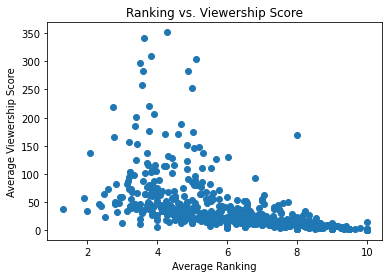

In [5]:
plt.scatter(average_ranking, viewer_score)
plt.xlabel("Average Ranking")
plt.ylabel("Average Viewership Score")
plt.title("Ranking vs. Viewership Score")
plt.show()

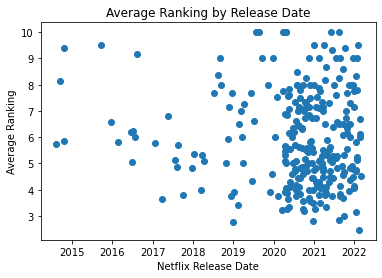

In [6]:
# Get a list of all of the dates in the dataset

date_raw = netflix["Netflix Release Date"].unique()
dates = []

# Convert the dates to datetime objects so that we can sort them in order
for date in date_raw:
    dates.append(datetime.strptime(date, '%b %d, %Y'))

dates.sort()

#remove the first one, since it is an outlier
dates.pop(0)
    
# Set up an empty list that we can add to as we go through the loop
average_ranking = []

# Note that the list dates contains a list of datetime objects, we use .strftime to convert it back
# to the format that the dataset uses
for date in dates:
    average_ranking.append(netflix["Rank"].loc[netflix["Netflix Release Date"] == date.strftime('%b %d, %Y')].mean())
    
plt.scatter(dates, average_ranking)
plt.xlabel("Netflix Release Date")
plt.ylabel("Average Ranking")
plt.title("Average Ranking by Release Date")

plt.show()

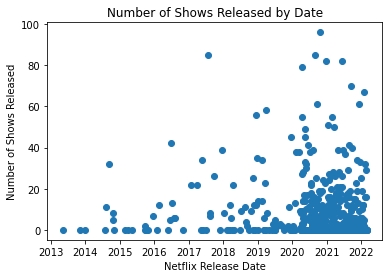

In [7]:
# This counts how many titles were released on each day

# I just realized that this counts how many times entries with that release date appear
# So titles that appear multiple times in the dataset count multiple times, so this data is a bit useless

released = []

for date in dates:
    released.append(netflix["Title"].loc[netflix["Netflix Release Date"] == date.strftime('%b %d, %Y')].count())
    
plt.scatter(dates, released)
plt.xlabel("Netflix Release Date")
plt.ylabel("Number of Shows Released")
plt.title("Number of Shows Released by Date")
plt.show()

In [8]:
# I was trying to split the dates by month and get total rankings for each month
# It didn't work, don't know why

jan_dates = []
feb_dates = []
mar_dates = []
apr_dates = []
may_dates = []
jun_dates = []
jul_dates = []
aug_dates = []
sep_dates = []
oct_dates = []
nov_dates = []
dec_dates = []

for date in dates:
    if date.strftime("%m") == "01":
        jan_dates.append(date)
    elif date.strftime("%m") == "02":
        feb_dates.append(date)
    elif date.strftime("%m") == "03":
        mar_dates.append(date)
    elif date.strftime("%m") == "04":
        apr_dates.append(date)
    elif date.strftime("%m") == "05":
        may_dates.append(date)
    elif date.strftime("%m") == "06":
        jun_dates.append(date)
    elif date.strftime("%m") == "07":
        jul_dates.append(date)
    elif date.strftime("%m") == "08":
        aug_dates.append(date)
    elif date.strftime("%m") == "09":
        sep_dates.append(date)
    elif date.strftime("%m") == "10":
        oct_dates.append(date)
    elif date.strftime("%m") == "11":
        nov_dates.append(date)
    elif date.strftime("%m") == "12":
        dec_dates.append(date)

month_list = [jan_dates, feb_dates,mar_dates,apr_dates,may_dates,jun_dates,jul_dates,aug_dates,sep_dates,oct_dates,nov_dates,dec_dates]

months = ["January","Feburary","March","April","May","June","July","August","September","October","November","December"]
monthly_rankings = []

for month in month_list:
    temp_rankings = []
    for date in month:
        temp_rankings.append(netflix["Rank"].loc[netflix["Netflix Release Date"] == date.strftime('%b %d, %Y')].mean())
        
    monthly_rankings.append(sum(temp_rankings) / len(temp_rankings))
    
monthly_rankings

    
netflix.loc[netflix["Netflix Release Date"] == dec_dates[1].strftime('%b %d, %Y')].mean()
dec_dates[1].strftime('%b %d, %Y')


'Dec 01, 2017'

In [29]:
# Here we use the omdb API to get some extra info on all of our titles, just saving the json file to a dictionary for now

titles = netflix["Title"].unique()
json_data = {}
url = "http://www.omdbapi.com/?t="
api_key = "&apikey=" + omdb_key

for title in titles:
    response = requests.get(url + title + api_key)
    data = response.json()
    json_data[title] = data



NameError: name 'tiger_king_rand_and_date' is not defined

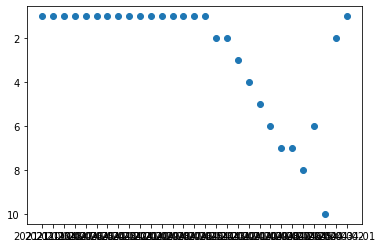

In [154]:
# the first entry in titles is for Tiger King, so I just do this instead of writing it's name over and over
tiger_king_times = netflix["As of"].loc[netflix["Title"] == titles[0]]
tiger_king_datetime = []
tiger_king_rank = netflix["Rank"].loc[netflix["Title"] == titles[0]]

# I get a list times and convert them to datetime objects
for time in tiger_king_times:
    tiger_king_datetime.append(datetime.strptime(time, '%Y-%m-%d'))
    
scatter = plt.scatter(x=tiger_king_times,y=tiger_king_rank)
ax = scatter.axes

# Invert axis so that 1 is on top
ax.invert_yaxis()

# Here I'm trying to get a list of all the unique dates and turn them into datetime objects so I can sort them
# The intent here is to build a dataframe with all the dates in a single column and then rankings on that date for an individual show in another 
# You can probably give it a column for every show to make graphing a shows change in position over time easier
as_of_dates = netflix["As of"].unique()
as_of_datetime = []

for date in as_of_dates:
    as_of_datetime.append(datetime.strptime(date, '%Y-%m-%d'))
as_of_datetime.sort()




tiger_king_rank_and_date = netflix[["As of","Rank"]].loc[netflix["Title"] == titles[0]]
tiger_king_rank_and_date["Rank"].loc[tiger_king_rank_and_date]

In [151]:
# Look at the top 10 list on 4/21/2020
netflix.loc[netflix["As of"] == "2020-04-21"]

# Look at all the shows that were at number 1
netflix.loc[netflix["Rank"] == 1]

# Get the list of unique titles
titles_top_10 = netflix["Title"].unique()

# We are going to get a list of days those titles were in the top 10, we start with an empty list
max_days_in_top_10 = []

# Loop through the titles and get the max number of days it was in the top 10 (This would be the total number of days it shows up)
for title in titles_top_10:
    max_days_in_top_10.append(netflix["Days In Top 10"].loc[netflix["Title"] == title].max())

max_days_in_top_10

# Turn that into a dataframe
max_days_in_top_10_df = pd.DataFrame({
    "Title":titles_top_10,
    "Max Days In Top 10":max_days_in_top_10
})

# Look at Tiger King's ranking
max_days_in_top_10_df.loc[max_days_in_top_10_df["Title"] == "Tiger King: Murder, Mayhem …"]

,Title,Max Days In Top 10
26,"Tiger King: Murder, Mayhem …",37


In [42]:
# 72 titles were not reconized by the API, here is a list of all of them 
titles_not_found = []

for title in titles:
    if json_data[title]['Response'] == 'False':
        titles_not_found.append(title)
        
titles_not_found

['Tiger King: Murder, Mayhem …',
 'Chris Dâ\x80\x99Elia: No Pain',
 '#blackAF',
 'Murder to Mercy: The Cyntoi…',
 'Workinâ\x80\x99 Moms',
 'Greyâ\x80\x99s Anatomy',
 'Have a Good Trip: Adventure…',
 'Cloudy with a Chance of Mea…',
 'The Last Days of American C…',
 'PokÃ©mon Journeys: The Series',
 'Eurovision Song Contest: Th…',
 'George Lopez: Weâ\x80\x99ll Do It f…',
 'I Now Pronounce You Chuck a…',
 'Dr. Seussâ\x80\x99 The Lorax',
 'The Epic Tales of Captain U…',
 'Transformers: War for Cyber…',
 'Worldâ\x80\x99s Most Wanted',
 'Wizards: Tales of Arcadia',
 'Game On: A Comedy Crossover…',
 'Bunkâ\x80\x99d',
 'Chefâ\x80\x99s Table: BBQ',
 '#Alive',
 'Jurassic World: Camp Cretac…',
 'Schittâ\x80\x99s Creek',
 'American Pie Presents: Girl…',
 'A Babysitterâ\x80\x99s Guide to Mon…',
 'My Next Guest Needs No Intr…',
 'The Queenâ\x80\x99s Gambit',
 'Chappelleâ\x80\x99s Show',
 'Illumination Presents The G…',
 'The Boss Baby: Back in Busi…',
 'The Princess Switch: Switch…',
 'The Christmas

In [74]:
# I was going to make a dataframe of all the OMDB data and save it to a csv file
# but I closed out of my original notebook and I can't call the api again without hitting the request limit, so I'll do this later

pprint(json_data["Ozark"])

actors = []
awards = []
country = []


{'Actors': 'Jason Bateman, Laura Linney, Sofia Hublitz',
 'Awards': 'Won 3 Primetime Emmys. 19 wins & 124 nominations total',
 'Country': 'United States',
 'Director': 'N/A',
 'Genre': 'Crime, Drama, Thriller',
 'Language': 'English',
 'Metascore': 'N/A',
 'Plot': 'A financial advisor drags his family from Chicago to the Missouri '
         'Ozarks, where he must launder money to appease a drug boss.',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BZDUxMWNlMTUtYTljZS00MTE0LTlkYjktOTU1ODZjYzBhMTk0XkEyXkFqcGdeQXVyMTEyMjM2NDc2._V1_SX300.jpg',
 'Rated': 'TV-MA',
 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '8.5/10'}],
 'Released': '21 Jul 2017',
 'Response': 'True',
 'Runtime': '60 min',
 'Title': 'Ozark',
 'Type': 'series',
 'Writer': 'Bill Dubuque, Mark Williams',
 'Year': '2017–2022',
 'imdbID': 'tt5071412',
 'imdbRating': '8.5',
 'imdbVotes': '265,778',
 'totalSeasons': '4'}


In [46]:
netflix.loc[netflix["Title"] == "Ozark"]

,As of,Rank,Year to Date Rank,Last Week Rank,Title,Type,Netflix Exclusive,Netflix Release Date,Days In Top 10,Viewership Score
1,2020-04-01,2,2,-,Ozark,TV Show,Yes,"Jul 21, 2017",5,45
11,2020-04-02,2,2,-,Ozark,TV Show,Yes,"Jul 21, 2017",6,54
21,2020-04-03,2,2,-,Ozark,TV Show,Yes,"Jul 21, 2017",7,63
31,2020-04-04,2,2,2,Ozark,TV Show,Yes,"Jul 21, 2017",8,72
41,2020-04-05,2,2,2,Ozark,TV Show,Yes,"Jul 21, 2017",9,81
...,...,...,...,...,...,...,...,...,...,...
6954,2022-02-25,5,5,5,Ozark,TV Show,Yes,"Jul 21, 2017",85,524
6967,2022-02-26,8,5,8,Ozark,TV Show,Yes,"Jul 21, 2017",86,527
6979,2022-02-27,10,8,7,Ozark,TV Show,Yes,"Jul 21, 2017",87,528
6986,2022-02-28,7,10,7,Ozark,TV Show,Yes,"Jul 21, 2017",88,532


In [155]:
# This code finds the list of genres mentioned in the netflix-titles csv file


genres = []

# The listed_in column is a string containing the netflix catagories it was in seperated by commas, so they get split up and added to the genres list
netflix_titles["listed_in"].unique()

for listed in netflix_titles["listed_in"].unique():
    for element in listed.split(","):
        genres.append(element)

# Then we don't want repeats       
genres_cleaned = []
for element in genres:
    if element not in genres_cleaned:
        genres_cleaned.append(element.strip())


genres_cleaned        


['Documentaries',
 'International TV Shows',
 'TV Dramas',
 'TV Mysteries',
 'Crime TV Shows',
 'International TV Shows',
 'TV Action & Adventure',
 'Docuseries',
 'Reality TV',
 'Romantic TV Shows',
 'TV Comedies',
 'TV Horror',
 'TV Mysteries',
 'Children & Family Movies',
 'Dramas',
 'Independent Movies',
 'International Movies',
 'British TV Shows',
 'Reality TV',
 'Comedies',
 'Dramas',
 'Docuseries',
 'International TV Shows',
 'International Movies',
 'Comedies',
 'Crime TV Shows',
 'Docuseries',
 'TV Dramas',
 'International Movies',
 'Spanish-Language TV Shows',
 'TV Dramas',
 'Thrillers',
 'Spanish-Language TV Shows',
 'TV Action & Adventure',
 'TV Action & Adventure',
 'TV Dramas',
 'International Movies',
 'International Movies',
 'Romantic Movies',
 'International TV Shows',
 'Reality TV',
 'International Movies',
 'Music & Musicals',
 'Horror Movies',
 'Sci-Fi & Fantasy',
 'International TV Shows',
 'TV Comedies',
 'TV Dramas',
 'TV Thrillers',
 "Kids' TV",
 'Internationa